# Bayesian parameter inference with the TRENTo inital condition model

## Overview of the model parameters

In this exerciese, we are going to use the Bayesian analysis technique to study the TRENTo model. 
1. Energy deposition relation: $p$
2. Nucleon size parameter: $w$ [fm]
3. Fluctuation parameter: $k$
4. Nucleon minimum-distance parameters: $d$
5. Energy density normalization: $N$


We are primarily interested in the in $p$ and $w$ parameter. Because we will only use the initial condition preidciton, some of the fluctuations that presents in the dynamical evolution will be effectively account into the $k$ value when compare to real data. Therefore, the precise value of $k$ will not be so interested. The nucleon minimum distance is also a very crude approximation for the actual repulsive core. Nevertheless, it is important to propagate the uncertainty of $k$ and $d$ into the determination of $p$ and $w$. Finally, the energy density normalization is multiplied to the energy deposition relation:

$$ \frac{de}{d\eta_s dx_\perp^2} = \tau \textrm{Norm} \times \left(\frac{T_A^p(x_\perp) + T_B^p(x_\perp)}{2}\right)^{1/p} $$ 

$$ T_{A, B}(x_\perp) =  \sum_{\textrm{participants} \in A. B} \gamma_i \rho(x_\perp-x_{\perp, i}) $$

Here, we are going to consider $N=\tau \textrm{Norm}$ as a single scale parameter. Again, its absolute value is not our interest.

## Data

Because we only studies initial condition prediciton, we will be focusing on two data set that are rather insensitive to the dynamical evolution, and more directly related to the initial condition. 

1. Total transverse energy as function of centrality at mid-rapidity $\sum E_T$ v.s. Centrality. Assume boost-incariance of the initial condition and the following dynamics on the rapidity distribution. The total energy deposited in initial condition is a good approximation of the final-state total transverse energy at mid-rapidity.

2. The scaled flow distribution $P(v_n/\langle v_n \rangle)$. This distributino is shown to be closely correlated with initial eccenticity distributions (assumes linear reponse of the dynamics) $P(\epsilon_n / \langle \epsilon_n \rangle)$.

### Pseudo-data

We will first apply the Bayesian procedure to infer these parameter from a set of pseudo-data generate by TRENTo calcualtion where we know what the true values of the parameters are. This practice is essential before applying your model+Bayesian to real-world data. In this so-called closesure test, one gets a better understand of the uncertainties in the Bayesian procedure, as the model should preferctly describe the pseudo-data, given the corrected parameters.

### Experimental data

Centrality dependent $\sum E_T$ in Pb+Pb at $\sqrt{s}=2.76$ TeV as measured by the ALICE experiment Phys. Rev. C 94 (2016) 034903.

Flow distribution in Pb+Pb at $\sqrt{s}=2.76$ TeV as measured by the ATLAS experiment JHEP11(2013)183.

In [1]:
########## Block 1 ############## <-- Please refer this block number when you ask questions
import subprocess
# packages for scientific computing
import numpy as np
from scipy.interpolate import interp1d
# package for plotting
import matplotlib.pyplot as plt
%matplotlib inline
# Pythonic interface to the HDF5 binary data format
import h5py
# Package for Markov chain Monte Carlo
import emcee

# scikit-learn: machine learning in Python
# https://scikit-learn.org/stable/tutorial/basic/tutorial.html
# In this example, we are using the principal component analysis 
# and the Gaussian process regression as implemented in sklearn.
# Detailed documentation of these modules:
# Principal component analysis (PCA): 
# https://scikit-learn.org/stable/modules/decomposition.html
# Gaussian process gressor (GPR)):
# https://scikit-learn.org/stable/modules/gaussian_process.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import \
     GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels

# suppression warning messages
import warnings
warnings.filterwarnings('ignore')

# some plot settings, not important
fontsize  = 12
plt.rcdefaults()
plt.rcParams.update({
    'font.size': fontsize,
    'legend.fontsize': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': True,
    'axes.spines.right': True,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
})


# Step 1: make design

We use the Latin hyper-cube sampling function implemented in the R program to generate unit ($0<x<1$) parameter design.

*Remark*: in principle, our parameter space is five-dimensional $p,w,k,d$ and $N$. And we should run the model on each set of the parameter to get the prediction. However, since the effect of normalization $N$ is simply additive to the intiial condition prediction to of the total energy. Therefore, there is no need to interpolate over $N$, and ut is sufficient to generate the design with only four parameters $p,w,k,d$.

Further, for fluctuation and nucleon minimum distance, we use $\sigma = 1/\sqrt{k}$ and $v = d_\min^3$ instead.
Therefore, the five parameters that we are going tune are:
1.   $-1 < p < 1$
2.   $.4 < w < 1.5 $ fm 
3.   $1/3 < \sigma < 3$: standard deviation of the $\Gamma$ fluctuation.
4.   $0<v<4$ fm${}^3$: minimum-distance cubed.
5.   $8 < N < 12$

In [2]:
########## Block 2 ##############
ParamLabels = ["p","w","s","v","N"]
ParamTexLabels = [r"$p$",r"$w$ [fm]", 
                  r"$\sigma$", r"$v$ [fm${}^3$]",
                  r"$N$"]
RangeWithLabels = {
                "p": [-1, 1],
               "w": [0.4, 1.5],
               "s": [1./3., 3.],
               "v": [0, 2.],
               "N": [6,16]
                }
ranges = np.array([
        RangeWithLabels[l] for l in ParamLabels
])
ndim = len(ParamLabels)

# This function load a pre-generated Latin-hypercube
# design of parameters [p, w, sigma, v] 
def load_existing_design(filename="ModelData/training-data/Design.dat"):
    Design = np.loadtxt(filename).T
    return Design

# This function sample completely random design
# We will compare its difference with LHS design
def Random_design(npoints, ranges, seed=12345):
    # Just in case you haven't install R yet...
    np.random.seed(seed)
    unitcube = np.random.rand(npoints, ranges.shape[0])
    Design = np.array([  
       (1.-x)*lower + x*upper
       for (lower, upper), x in zip(ranges, unitcube.T)
    ])
    return Design

In [3]:
########## Block 3 ##############
# Load existing design
Design = load_existing_design()
print("shape of design:", Design.shape)
Npoints = Design.shape[1]
# Generate a random design
RandomDesign = Random_design(Npoints, ranges[:4])

shape of design: (4, 100)


Check the distribution of the design parameters
1. Single parameter distribution should be uniform
2. Pair-wise distribution covers the 2D range
3. Comparison with completely randomized design

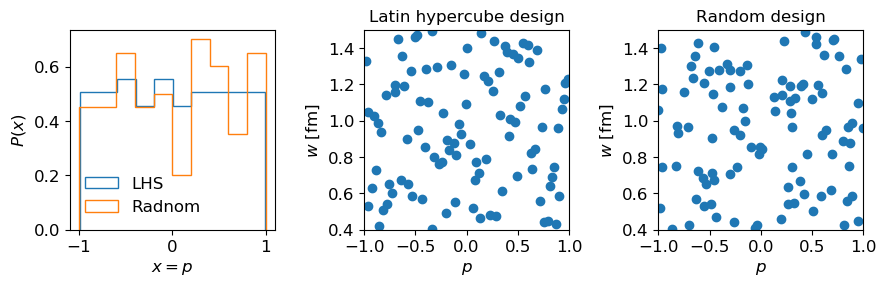

In [4]:
########## Block 4 ##############
# we have three subplots to check
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9,3))

# In subplot 1, check the one parameter distribution,
# and compare to the one generated in random design
ax1.hist(Design[0], bins=10, histtype='step', 
         density=True, label='LHS')
ax1.hist(RandomDesign[0], bins=10, histtype='step', 
         density=True, label='Radnom')
ax1.legend(loc='lower left')
ax1.set_xlabel(r"$x=$"+ParamTexLabels[0])
ax1.set_ylabel(r"$P(x)$")

# In subplot 2, check the two-parameter scatter plot
ax2.scatter(Design[0], Design[1])
ax2.axis([*ranges[0], *ranges[1]])
ax2.set_xlabel(ParamTexLabels[0])
ax2.set_ylabel(ParamTexLabels[1])
ax2.set_title("Latin hypercube design")

# In subplot 3, check the two-parameter scatter plot
# for Random design
ax3.scatter(RandomDesign[0],RandomDesign[1])
ax3.axis([*ranges[0], *ranges[1]])
ax3.set_xlabel(ParamTexLabels[0])
ax3.set_ylabel(ParamTexLabels[1])
ax3.set_title("Random design")

plt.tight_layout(True)

## Step 2: Running the physical model on design parameters and compute the observables

For a complex mode, this step is the most time consuming piece of the Bayesian analysis. Even though we only use initial condition model to make predictions (TRENTo O(100) events/s, versus full model, O(10) events / hour), it is still time consuming if you have to generated tens of thousands of events using each of the 100 different parameter set. Therefore, we will just load pre-generated TRENTo data / observables at the hands-on session. 

*Remark* when you do the calcualtion on your own, it is always good to estimate the computing time when planning the design points.

In [5]:
########## Block 5 ##############
# Function that calls TRENTo to generate events, looping over
# each set of design parameters
# *Will not be used during this hands-on session
TRENTo_dtype=[('idx',np.int,1),
              ('b', np.float,1),
              ('npart', np.int,1),
              ('ET', np.float,1),
              ('e2', np.float,1),  
              ('e3', np.float,1),  
              ('e4', np.float,1),  
              ('e5', np.float,1),  
             ]
def call_TRENTo(p, w, s, v, 
                Nevents=10000, save2file="trento-data.h5"):
    for i, (ip, iw, isigma, iv) in enumerate(zip(p, w, s, v)):
        print("Generating point ", i, 
              " p={:1.3f}, w={:1.3f}, sigma={:1.3f}, v={:1.3f}".format(ip, iw, isigma, iv)
             )
        proc = subprocess.run(
            ['trento', 
             'Pb','Pb', '{:d}'.format(Nevents),
             '-x','6.4', 
             '-n','1.0',
             '-p','{:1.3f}'.format(ip), 
             '-w','{:1.3f}'.format(iw), 
             '-k','{:1.3f}'.format(1/isigma**2), 
             '-d','{:1.3f}'.format(iv**(1./3.)), 
            ],
            stdout=subprocess.PIPE
        )
        results = []
        for l in proc.stdout.splitlines():
            e1 = np.empty(1,dtype=TRENTo_dtype)
            for it, value in zip(TRENTo_dtype, l.split()):
                e1[it[0]] = value
            results.append(e1[0])
        results = np.array(results)
        with h5py.File(save2file,'a') as f:
            groupname = "{:d}/".format(i)
            #if groupname in f:
            #    del f[groupname]
            g = f.create_group(groupname)
            g.attrs['p'] = ip
            g.attrs['w'] = iw            
            g.attrs['s'] = isigma
            g.attrs['v'] = iv
            for it, value in zip(TRENTo_dtype[1:], l.split()[1:]):
                g.create_dataset(it[0], data=results[it[0]], dtype=it[1])    

In [6]:
########## Block 6 ##############
# *Will not be used during this hands-on session
#call_TRENTo(Design[0], Design[1], Design[2], Design[3], Nevents=1000,)

Load the calcualtion and compute observabeles:
1. Centrality is defined by $\sum E_T$ in the calculation.
2. The full distribution $P(\epsilon_n/\langle \epsilon_n \rangle)$ requires very high statistics. So instead, we will compare the width (std) and skewness of the distribution to experiments.

In [7]:
########## Block 7 ##############
def std_and_skewness_with_uncertainty(x):
    n = len(x)
    std1 = np.sqrt( ((x-x.mean())**2).mean() )
    skew1 = ((x-x.mean())**3).mean() / std1**3
    std = np.sqrt(n/(n-1)) * std1
    std_err = std/np.sqrt(2*n-2)
    skew = np.sqrt(n*(n-1))/(n-1) * skew1
    skew_err= np.sqrt(6*n*(n-1)/((n-2)*(n+1)*(n+3)))
    return std, std_err, skew, skew_err

# This function load the pre-generated trento data, 
# including impact-parameter(b),
# number-of-particpant (Npart)
# dE/deta_s (ET)
# eccentricitly, n=2,3,4,5
# 40,000 events were generated at each design point.
# At each design point, ET is calculated as function 
# of centrality, P(en/<en>) is calcualted at 20-25% 
# and 40-45% centrality, n=2,3,4. 
def LoadAndComputeObs(filename="ModelData/trento-data/design-raw.h5"):
    obs = {}
    with h5py.File(filename, "r") as f:
        for i in range(len(list(f.keys()))):
            it = "{:d}".format(i)
            obs[it] = {}
            ET = f[it]['ET'].value
            # sort events with ET
            index = np.argsort(ET)[::-1]
            ET = ET[index]
            e2 = f[it]['e2'].value[index]
            e3 = f[it]['e3'].value[index]
            e4 = f[it]['e4'].value[index]
            Nevents = len(ET)
            cen = np.array([0, 2.5, 5, 7.5, 10, 
                            12.5, 15, 17.5, 20, 
                            22.5, 25, 27.5, 30, 
                            32.5, 35, 37.5, 40, 
                            45, 50, 55, 60, 
                            65, 70, 75, 80])
            cenidx = (cen/100.*Nevents).astype(int)
            obs[it]['ET']={
                'x': (cen[1:]+cen[:-1])/2.,
                'y': np.array([
                    ET[il:ih].mean()
                    for il, ih in zip(cenidx[:-1],cenidx[1:])
                ]),
                'stat': np.array([
                    ET[il:ih].std()/np.sqrt(ih-il-1)
                    for il, ih in zip(cenidx[:-1],cenidx[1:])
                ])
            }

            for n, data in zip([2,3,4], [e2, e3, e4]):
                for (cl, ch) in [(20,25),(40,45)]:
                    i1 = int(cl/100.*Nevents)
                    i2 = int(ch/100.*Nevents)
                    x = data[i1:i2]/data[i1:i2].mean()
                    H, bins = np.histogram(x, bins=32, range=(0,3.2), density=True)
                    std, std_err, skew, skew_err = \
                        std_and_skewness_with_uncertainty(x)
                    obs[it]['Pe{:d}-{:d}-{:d}'.format(n,cl,ch)]={
                        'x': (bins[1:]+bins[:-1])/2.,
                        'y': H,
                    }
                    obs[it]['Me{:d}-{:d}-{:d}'.format(n,cl,ch)]={
                        'std': std, 'std-err': std_err,
                        'skew': skew, 'skew-err': skew_err,
                    }
    return obs

First, plot the experimental data as a reference

In [8]:
########## Block 8 ##############
#plot experimental data as a reference
def plot_exp(axes):
    x, xl, xh, ET, ETstat, ETsys = np.loadtxt("ExpData/ALICE-ET.dat",usecols=[0,1,2,3,4,6]).T
    axes[0].errorbar(x, ET, xerr=(xh-xl)/2., yerr=ETstat,label='ALICE',fmt='k.',markersize=2)
    for (ixl, ixh, iy, iss) in zip(xl, xh, ET, ETsys):
        axes[0].fill_between([ixl,ixh],[iy-iss,iy-iss],
                    [iy+iss,iy+iss],facecolor='none',
                    edgecolor='k')
    axes[0].set_xlabel("Centrality(%)")
    axes[0].set_ylabel(r"$d\sum E_T/d\eta_s$ [GeV]")
    axes[0].legend()

    cenL, cenH = 40, 45
    for ax, n in zip(axes[1:], [2,3,4]):
        x, y, stat, sp, sm = np.loadtxt("ExpData/ATLAS-Pv{}-{}-{}.dat".format(n,cenL,cenH), 
                                            usecols=[0,1,2,4,5]).T
        f = interp1d(x, y, kind='linear')
        X = np.linspace(x.min(),x.max(),100)
        xmean = (f(X)*X).sum()/f(X).sum()
        ax.errorbar(x/xmean, y*xmean, yerr=stat*xmean, label='ATLAS, \n n={:d}, {:d}-{:d}%'.format(n,cenL,cenH), fmt='k.')
        for ix, iy, ip, im in zip(x/xmean, y*xmean, sp*xmean, sm*xmean):
            ax.fill_between([ix-.02, ix+.02], [iy+im, iy+im], [iy+ip, iy+ip], edgecolor='k', facecolor='none')
        ax.legend(loc='lower left')
        ax.semilogy()
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$P(x)$")
        ax.set_title(r"$x = v_{}/\langle v_{} \rangle$ or $\epsilon_{}/\langle \epsilon_{} \rangle$".format(n,n,n,n))
        
    plt.tight_layout(True)

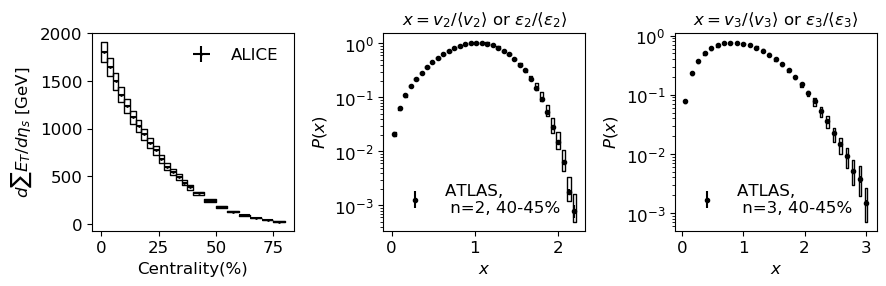

In [9]:
########## Block 9 ##############
# plot the experimental data:
# ALICE: ET v.s. Centrality
fig, axes = plt.subplots(figsize=(9,3), ncols=3)
plot_exp(axes)

Next, overlay our calculaton at the design porints to the experimental value. Which observable might help to contrain the parameters?

In [10]:
########## Block 10 ##############
def plot_design(obs, axes):    
    # Since we did not include the noramlization in the design calcualtion,
    # We simple multiply by the calcualtion by unifrom distributed random 
    # varaible to show the spread of prediction stems from a varying normalization.
    for key in obs:
        it = obs[key]
        axes[0].plot(it['ET']['x'], 
                 it['ET']['y']*np.random.uniform(6,16),
                 color='b', 
                 alpha=0.1
        )
    axes[0].set_xlabel("Centrality(%)")
    axes[0].set_ylabel(r"$\sum E_T$ [GeV]]")
    
    cenL, cenH = 40, 45
    for ax, n in zip(axes[1:], [2,3]):
        for key in obs:
            it = obs[key]
            ax.plot(it['Pe{}-{}-{}'.format(n,cenL,cenH)]['x'], 
                     it['Pe{}-{}-{}'.format(n,cenL,cenH)]['y'],
                     color='b', 
                     alpha=0.1
            )
        ax.semilogy()
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$P(x)$")
        ax.set_title(r"$x = v_{}/\langle v_{} \rangle$ or $\epsilon_{}/\langle \epsilon_{} \rangle$".format(n,n,n,n))
        
    plt.tight_layout(True)

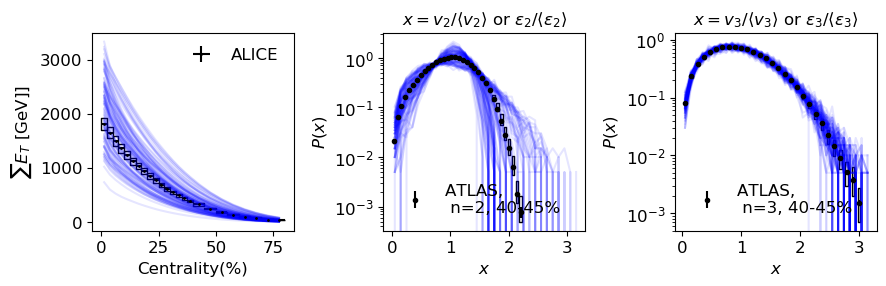

In [11]:
########## Block 11 ##############
obs = LoadAndComputeObs()
fig, axes = plt.subplots(figsize=(9,3), ncols=3)
plot_exp(axes)
plot_design(obs, axes)

It is hard to directly compare the distribution of $v_n/\langle \langle v_n\rangle$ with $\epsilon_n/\langle \langle \epsilon_n\rangle$ in the Bayesian analysis. Because it requrires very high statistics to get the detil of the tails of the distribution. Therefore we choose to compare the standard-deviation and skewness of the distribution. The list of our observables are:
$$ Y_{\textrm{calc}} = \left[ \underbrace{\frac{dE_T}{d\eta}[0-2.5\%],\cdots, \frac{dE_T}{d\eta}[75-80\%], }_{\textrm{24 values}}\\ \underbrace{\sigma_{\tilde{\epsilon}_2}[20-25\%] , \sigma_{\tilde{\epsilon}_3}[20-25\%], \gamma_{\tilde{\epsilon}_2}[20-25\%], \gamma_{\tilde{\epsilon}_3}[20-25\%],}_{\textrm{4 values}} \\
\underbrace{\sigma_{\tilde{\epsilon}_2}[20-25\%], \sigma_{\tilde{\epsilon}_3}[40-45\%], \gamma_{\tilde{\epsilon}_2}[40-45\%],\gamma_{\tilde{\epsilon}_3}[40-45\%]}_{\textrm{4 values}} \right] $$
The model prediction consists of 36 values at each design point.

Consturct $Y_{\textrm{calc}}$

In [12]:
########## Block 12 ##############
# These function organize the TRETNo calculation into the 
# above observable array
# model_data: 100 rows, 36 columns
def organize_model_data():
    model_data = np.array([
        [ *list(obs[it]['ET']['y']), 
            obs[it]['Me2-20-25']['std'], obs[it]['Me3-20-25']['std'],
            obs[it]['Me2-40-45']['std'],  obs[it]['Me3-40-45']['std'],
            obs[it]['Me2-20-25']['skew'], obs[it]['Me3-20-25']['skew'],
            obs[it]['Me2-40-45']['skew'], obs[it]['Me3-40-45']['skew'],
        ]  for it in obs 
    ])
    return model_data

# Or, you can simply use the following function to
# load the pre-generated observable array
def load_precalculated_model_data(filename="ModelData/training-data/design-obs.h5"):
    with h5py.File(filename, "r") as f:
        N = len(f.keys())
        model_data = np.array([
                f["{:d}".format(i)].value  for i in range(N)
            ])   
    return model_data

model_data = organize_model_data()

Take a look at the distribution of the design calculation

In [13]:
########## Block 13 ##############
def plot_design_2(model_data, axes):    
    for it in model_data:
        axes[0].plot(obs['0']['ET']['x'], 
                     it[:24]*np.random.uniform(6,16), 
                     color='b', alpha=0.1)
    axes[0].set_xlabel("Centrality(%)")
    axes[0].set_ylabel(r"$E_T$")
    print(model_data.shape)
    axes[1].violinplot(model_data[:,24:], np.arange(8), showextrema=False, widths=1)
    axes[1].set_xticks(np.arange(8))
    axes[1].set_xticklabels([r"$\sigma_2$, 20-25%", r"$\sigma_3$, 20-25%",
                             r"$\sigma_2$, 40-45%", r"$\sigma_3$, 40-45%",
                             r"$\gamma_2$, 20-25%", r"$\gamma_3$, 20-25%",
                             r"$\gamma_2$, 40-45%", r"$\gamma_3$, 40-45%"], rotation=70)
    axes[1].set_ylabel(r"Moments of $P(\epsilon_2/\langle\epsilon_n \rangle)$")
    plt.tight_layout(True)

(100, 32)


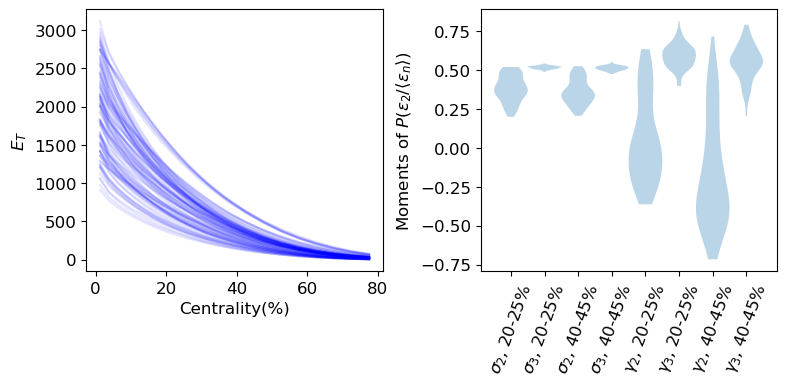

In [14]:
########## Block 14 ##############
fig, axes = plt.subplots(figsize=(8,4), ncols=2)
plot_design_2(model_data, axes)

Left: the 100 curves of $E_T$ v.s. Centrality from the TRENTo calculation at the 100 design point.

Right: we plot the distribution of, e.g., sigma(epsilon_2) using the so-called violin plot.
$$ \textrm{$x$-width of the shape} \propto \textrm{density of calcualtions at the $y$-value} $$
A useful way to visualize the distribution of the design calculations.

## Interpolate the design calculation

Next, we need to figure out how to predict the outcome of TRETNo calculation at novel parameter point. This is decomposed into two steps:
1. Dimensional reduction using principal component analysis.
2. Gaussian process regression on the parameter-dependences of dominatnt principale components.
3. Validate this interpolation works as expected.

### Step 1. Dimensional reduction via Principal Component Analysis (PCA)



In [15]:
########## Block 15 ##############
# This class take care most of the PCA functionalities that 
# we need in this example:
# 1. Transofrm design calculations into principal components
# model_data 100 x 36 --> PCs 100 x 36 --> 36 principal components
# 2. Selection of the first N=Npc dominant PCs
# PCs 100 x 36 --> 100 x Npc dominant PCs
# 3. Transfomation of prediction in the PC space 
#    back to the original observable space
# Npc PCs --> 36 obserbvables
# 4. Transofrmation of prediction covariance in the PC space
#    back to the original observable space
# Cov Npc x Npc (diagonal) --> Cov 36 x 36 --> prediction uncertainty
class Standardlization_PCA:
    def __init__(self, data, Npc):
        self.npc = Npc
        self.scaler = StandardScaler(copy=True)
        self.pca = PCA(copy=True, whiten=True, svd_solver='full')

        # Store the first Npc tranformed observables
        self.TransformedObs = self.pca.fit_transform(self.scaler.fit_transform(data))[:,:Npc]
        # Features of each PC
        self.Features = self.pca.components_
        # The transformation matrix from PC to Physical space
        self.TransformationMatrix = (np.sqrt(self.pca.explained_variance_[:Npc])\
                                    * self.pca.components_[:Npc,:].T).T \
                                    * self.scaler.scale_

        A = (np.sqrt(self.pca.explained_variance_[Npc:])\
            * self.pca.components_[Npc:,:].T).T \
            * self.scaler.scale_
        self.ResidualCov = np.dot(A.T*1., A)
        # cumulative sum of the explained variance
        self.CumulativeVariance = np.cumsum(self.pca.explained_variance_ratio_)
    def PC2Obs(self, PCs):
        return np.dot(PCs, self.TransformationMatrix) + self.scaler.mean_
    def PCcov2Obscov(self, PCcov, with_truncation_err=True):
        results = np.matmul(self.TransformationMatrix.T*PCcov, self.TransformationMatrix)
        if with_truncation_err:
            return results+self.ResidualCov
        else:
            return results
        

In [16]:
########## Block 16 ##############
# Choose the number of principal components,
npc = 6
# And constuct the PCA transfromer
transformer = Standardlization_PCA(model_data, Npc=npc)

Linear correlation coefficients:  2.1611211240555402e-17


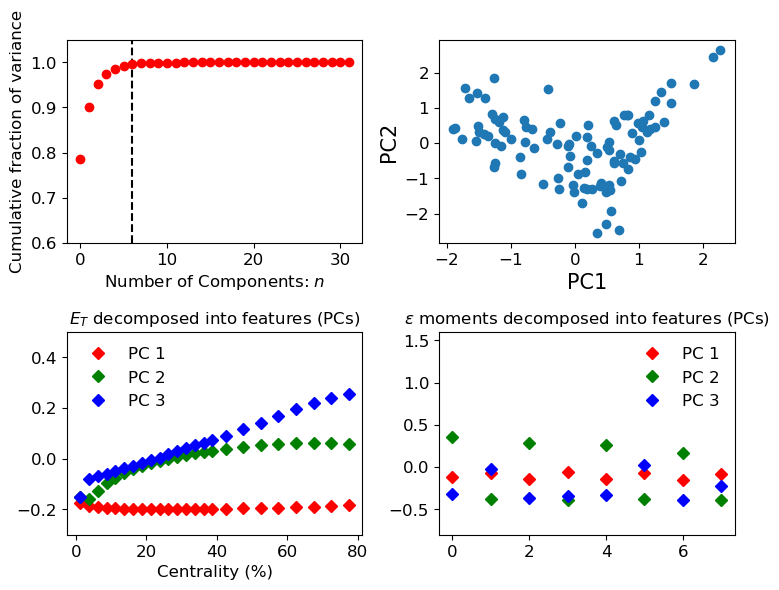

In [17]:
########## Block 17 ##############
# In this block, let's examine
# 1. Which PCs are important?
# 2. What PCs look like?
# 3. Are they linealy uncorrelated?
# 4. Are their residue non-linear correlation?
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(ncols=2, nrows=2,
                                            figsize=(8,6))

# Subplot 1: plot the cumulative variance contained in the first 
#            n principle components
ax1.plot(transformer.CumulativeVariance,'ro')
ax1.set_xlabel(r'Number of Components: $n$')
ax1.set_ylabel('Cumulative fraction of variance')
ax1.vlines(npc, .6, 1.2, linestyles='dashed')
ax1.set_ylim(.6,1.05)

# Subplot 2: plot the 2D scattered plot of any two PCs
#            Check the covariance between them, are they small?
#            Is there some non-linear structure in the plot?
Z1 = transformer.TransformedObs[:, 0]
Z2 = transformer.TransformedObs[:, 1]
ax2.scatter(Z1, Z2)
cov = np.cov(Z1, Z2)
print("Linear correlation coefficients: ", 
      cov[1,0]/np.sqrt(cov[0,0]*cov[1,1]))
ax2.set_xlabel('PC1', fontsize=15)
ax2.set_ylabel('PC2', fontsize=15)


# Subplot 3-4: plot the first few pinciple components
#              a new basis for parametrzing the D.o.F
#              present in the observables.
for i, (it, color) in \
        enumerate(zip(transformer.Features, 'rgb')):
    ax3.plot(obs['0']['ET']['x'],it[:24], 'D', color=color, label='PC {}'.format(i+1))
ax3.set_xlabel('Centrality (%)')
ax3.set_title(r"$E_T$ decomposed into features (PCs)")
ax3.legend()
ax3.set_ylim(-.3, .5)


for i, (comp, color) in \
        enumerate(zip(transformer.Features, 'rgb')):
    ax4.plot(comp[24:], 'D', color=color, label='PC {}'.format(i+1))
ax4.set_title(r"$\epsilon$ moments decomposed into features (PCs)")
ax4.legend()
ax4.set_ylim(-.8,1.6)

plt.tight_layout(True)

### Step 2:Training Gaussian process regressor to predict at "arbitrary" input parameters

First, train
$$\textrm{GP}_1: \textrm{parameters} \rightarrow Z_1$$
$$\cdots$$
$$\textrm{GP}_{N_{pc}}: \textrm{parameters} \rightarrow Z_{N_{pc}}$$
Then,
$$\textrm{New parameters}^* \xrightarrow{\textrm{GP}_1\cdots, \textrm{GP}_{N_{pc}}} Z^*_1,\cdots, Z^*_{N_{pc}} \xrightarrow{\textrm{PCA, inverse transformation}} \textrm{Prediction of observables}~\left[y_1, \cdots y_{36}\right]$$

In [18]:
########## Block 18 ##############

# Kernel function of Gaussion Process
# k(p1, p2) = C^2 * exp(-.5*(p1-p2)^2/L^2) + \delta(p1, p2)*level^2
# Range of hyper parameters:
# C: O(1)
# .2*(Pmax-Pmin) < L < 10*(Pmax-Pmin)
# 10^{-3} < NoiseLevel < 10^3
Lrange = ranges[:4,1]-ranges[:4,0]
kernel = (
    1. * kernels.RBF(
        length_scale=[1]*4,
        length_scale_bounds=np.outer(Lrange, (.2, 10.))
    )  
    + kernels.WhiteKernel(
        noise_level=1., 
        noise_level_bounds=(1e-3, 1e2))
)

# Build and train each GP
gps = [ GPR(kernel=kernel, n_restarts_optimizer=4) 
        for i in range(npc) ]
for i, gp in enumerate(gps):
    gp.fit(Design.T, transformer.TransformedObs[:,i])
    print('RBF: ', gp.kernel_.get_params()['k1'])
    print('White: ', gp.kernel_.get_params()['k2'])

RBF:  1.39**2 * RBF(length_scale=[0.865, 0.642, 4.83, 20])
White:  WhiteKernel(noise_level=0.00103)
RBF:  3.36**2 * RBF(length_scale=[1.6, 1.71, 5.74, 16.4])
White:  WhiteKernel(noise_level=0.0774)
RBF:  1.45**2 * RBF(length_scale=[0.823, 0.927, 3.26, 20])
White:  WhiteKernel(noise_level=0.0314)
RBF:  0.458**2 * RBF(length_scale=[0.4, 0.348, 26.7, 20])
White:  WhiteKernel(noise_level=0.816)
RBF:  0.836**2 * RBF(length_scale=[0.741, 0.389, 0.885, 7.24])
White:  WhiteKernel(noise_level=0.491)
RBF:  0.465**2 * RBF(length_scale=[1.26, 0.22, 0.533, 0.627])
White:  WhiteKernel(noise_level=0.782)


The "optimized" hyper-parameters are listed above. Are they reasonable?

### Step 3: Validating the Gaussian process

In [19]:
########## Block 19 ##############
#ParamRanges = {"p": [-1, 1],
#               "w": [0.4, 1.5],
#               "s": [1./3., 3.],
#               "v": [0, 2.],
#               "N": [6,16]

# For simplicity, we only choose three sets of novel parameters
# to compare the interpolated results from GP to real model 
# calcualtion. 
# In reality, one should do extensive validation test, instead of 
# just using a few of validation point.
validation_parameters = np.array([
#    p   w   sigma   v
    [.2, .5, 1.2, .3],
    [.5, .7, 1.4, 1.2],
    [-.5, 1., .7, 1.],
])
#call_TRENTo(*(validation_parameters.T), save2file="validation-data.h5")

In [20]:
########## Block 20 ##############
# This function takes parameter point as input,
# and outpus prediction of model calcualtion using GPs
# as well as the prediction uncertainty (1 sigma)
def GP_pred_at_one_input(parameter, with_truncation_err=True):
    pcs, pcstd = np.array([gp.predict([parameter], return_std=True) for gp in gps]).T[0]
    pred = transformer.PC2Obs(pcs)
    pred_err = np.sqrt( np.diag( transformer.PCcov2Obscov(pcstd**2, with_truncation_err) ) )
    return pred, pred_err

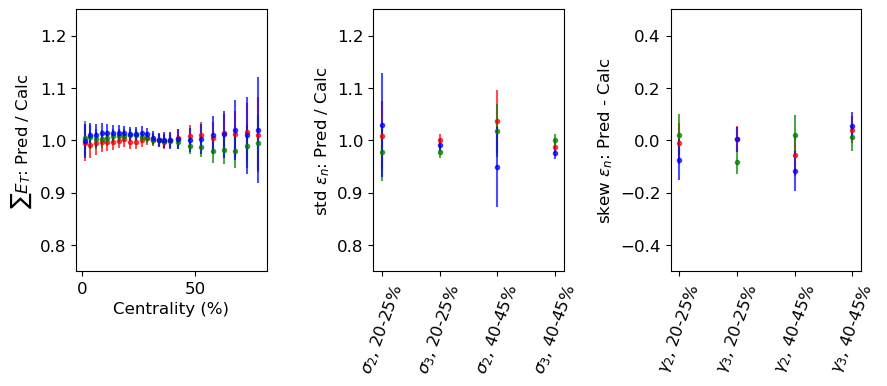

In [21]:
########## Block 21 ##############
# Run this block, the generated plot compares your trained GP 
# prediciton to the real model calculation at these three
# validation point.
# Question: what happens if you include much less or much more PC
# Go back to block 16, try npc=2,6,10, and regenerated this plot.
ValidatingData = LoadAndComputeObs(filename="ModelData/trento-data/validation-raw.h5")
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9,4))
for parameter, key, color in zip(validation_parameters, ValidatingData, 'rgb'):
    yobs = ValidatingData[key]
    calc = np.array([
                *list(yobs['ET']['y']), 
                yobs['Me2-20-25']['std'], yobs['Me3-20-25']['std'], 
                yobs['Me2-40-45']['std'], yobs['Me3-40-45']['std'],
                yobs['Me2-20-25']['skew'], yobs['Me3-20-25']['skew'], 
                yobs['Me2-40-45']['skew'], yobs['Me3-40-45']['skew'],
               ])
    # GP prediction
    pred, pred_err = GP_pred_at_one_input(parameter, with_truncation_err=True)
    # model calcuatlion
    ax1.errorbar(yobs['ET']['x'], pred[:24]/calc[:24], yerr=pred_err[:24]/calc[:24], fmt=color+'.', alpha=0.7)
    ax2.errorbar(np.arange(4), pred[24:28]/calc[24:28], yerr=pred_err[24:28]/calc[24:28], fmt=color+'.', alpha=0.7)
    ax3.errorbar(np.arange(4), pred[28:]-calc[28:], yerr=pred_err[28:], fmt=color+'.', alpha=0.7)
    
ax1.set_xlabel('Centrality (%)')
ax1.set_ylabel(r'$\sum E_T$: Pred / Calc')
ax2.set_ylabel(r'std ${\epsilon_n}$: Pred / Calc')
ax3.set_ylabel(r'skew ${\epsilon_n}$: Pred - Calc')
ax1.set_ylim(.75,1.25)
ax2.set_ylim(.75,1.25)
ax3.set_ylim(-.5, .5)
ax2.set_xticks(np.arange(4))
ax2.set_xticklabels(
    [r"$\sigma_2$, 20-25%",r"$\sigma_3$, 20-25%",
    r"$\sigma_2$, 40-45%",r"$\sigma_3$, 40-45%"],
    rotation=70)
ax3.set_xticks(np.arange(4))
ax3.set_xticklabels(
    [r"$\gamma_2$, 20-25%",r"$\gamma_3$, 20-25%",
    r"$\gamma_2$, 40-45%",r"$\gamma_3$, 40-45%"],
    rotation=70)
plt.tight_layout(True)

## Step 6 Model-to-data comparison

### 6.1 Choose the ''experimental'' data

1. Pseudo-data : let us use one of the validation point as the pseudo data
2. Experimental data.

In [22]:
########## Block 22 ##############
UsePseudoData = False
PseudoDataIdx = 2
if UsePseudoData:
    Norm = 12.
    yobs = ValidatingData['{:d}'.format(PseudoDataIdx)]
    parameter_truth = list(validation_parameters[PseudoDataIdx])+[Norm]
    yexp = np.array([
                *list(yobs['ET']['y']*Norm), 
                yobs['Me2-20-25']['std'], yobs['Me3-20-25']['std'],
                yobs['Me2-40-45']['std'], yobs['Me3-40-45']['std'],
                yobs['Me2-20-25']['skew'], yobs['Me3-20-25']['skew'],
                yobs['Me2-40-45']['skew'], yobs['Me3-40-45']['skew']
               ])
    ystat = np.array([
                *list(yobs['ET']['stat']*Norm), 
                yobs['Me2-20-25']['std-err'], yobs['Me3-20-25']['std-err'],
                yobs['Me2-40-45']['std-err'], yobs['Me3-40-45']['std-err'],
                yobs['Me2-20-25']['skew-err'], yobs['Me3-20-25']['skew-err'], 
                yobs['Me2-40-45']['skew-err'], yobs['Me3-40-45']['skew-err']
               ])
    ysys = np.zeros_like(ystat)
    print("Using pseudo-data")
    print("Truth of parameters: ")
    print("p={:1.3f}, w={:1.3f}, s={:1.3f}, v={:1.3f}, N={:1.3f}".format(*parameter_truth))
else:
    print("Using exp-data")
    ET, ETstat, ETsys = np.loadtxt("ExpData/ALICE-ET.dat",usecols=[3,4,6]).T
    yexp = list(ET)
    ystat = list(ETstat)
    ysys = list(ETsys)
    # compute std and skew from the distribution
    for mom in ['std','skew']:
        for (cenL, cenH) in [(20,25),(40,45)]:
            for n in [2,3]:
                x, y, stat, sp, sm = np.loadtxt("ExpData/ATLAS-Pv{}-{}-{}.dat".format(n,cenL,cenH), 
                                            usecols=[0,1,2,4,5]).T
                
                # sacle the mean
                f = interp1d(x, y, kind='linear')
                X = np.linspace(x.min(),x.max(),100)
                xmean = (f(X)*X).sum()/f(X).sum()
                std = np.average( (X/xmean-1.)**2, weights= f(X) )**.5
                skew = np.average( (X/xmean-1.)**3, weights= f(X) ) / std**3
                if mom=='std':
                    yexp = yexp + [std]
                if mom == 'skew':
                    yexp = yexp + [skew]
                ysys = ysys + [std*.05]
                ystat = ystat + [skew*.05]    
    yexp = np.array(yexp)
    ysys = np.array(ysys)
    ystat = np.array(ystat)

Using exp-data


In [23]:
########## Block 23 ##############
from scipy.linalg import lapack
# calculate the log of Gaussian density with 
# residual dy = y-mu and covariance matrix cov.
# - 1/2 * dy^T * cov^[-1] * dy - 1/2*ln(|cov|)
def lnLL(dy, cov):
    L, info = lapack.dpotrf(cov, clean=False)
    alpha, info = lapack.dpotrs(L, dy)
    return -.5*np.dot(dy, alpha)-np.log(L.diagonal()).sum()

####### Step 5: Construct the posterior #################
def prior_ln_pdf(theta):
    if (theta<ranges[:,0]).any() or (theta>ranges[:,1]).any():
        return -np.inf
    else:
        return 0.

cov_exp = np.diag(ystat**2) + np.diag(ysys**2)

def likelihood_ln_pdf(theta):
    Norm = theta[-1]
    pcs, pcstd = np.array([gp.predict([theta[:-1]], return_std=True) for gp in gps]).T[0]
    pred = transformer.PC2Obs(pcs)
    cov_pred = transformer.PCcov2Obscov(pcstd**2, with_truncation_err=True)
    pred[:24] *= Norm
    cov_pred[:24,:] *= Norm
    cov_pred[:,:24] *= Norm
    dy = pred-yexp
    cov = cov_exp + cov_pred
    return lnLL(dy, cov)

# Finally ln(Posterior) = ln(prior) + ln(likelihood)
def posterior_ln_pdf(theta):
    ln_pr = prior_ln_pdf(theta)
    ln_like = likelihood_ln_pdf(theta) 
    return ln_pr + ln_like

In [24]:
########## Block 24 ##############
def MCMC_generate(ranges, nsteps=1000, nburnin=200, ndim=5, nwalkers=100):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior_ln_pdf)
    # Burn in steps
    p0 = np.random.rand(nwalkers, ndim)
    p0 = (1.-p0)*ranges[:, 0] +  p0*ranges[:, 1]
    sampler.run_mcmc(p0, nburnin)
    # Production run
    p1 = sampler.chain[:,-1,:]
    sampler.run_mcmc(p1, nsteps)
    return sampler.chain.reshape((-1, ndim))

def Load_MCMC_chain(UsePseudoData, PseudoDataIdx, file='chain.h5'):
    with h5py.File(file, 'r') as f:
        if not UsePseudoData:
            samples = f['real-data'].value
        else:
            samples = f['validation-{:d}'.format(PseudoDataIdx)].value
    return samples

def Write_MCMC_chain(data, parameter_truth, UsePseudoData, PseudoDataIdx, file='chain.h5'):
    with h5py.File(file, 'a') as f:
        if not UsePseudoData:
            f.create_dataset("real-data", data=data, dtype=np.float)
        else:
            d = f.create_dataset('validation-{:d}'.format(PseudoDataIdx), data=data, dtype=np.float)
            d.attrs['truth'] = parameter_truth
    return samples

In [25]:
########## Block 25 ##############
ndim = 5
# load pre-generated chain
#samples = Load_MCMC_chain(UsePseudoData, PseudoDataIdx)

# Generate your own chain, don't use this with the online Binder server, it is slow!
# Use it if you are using your own computer
samples = MCMC_generate(ranges=ranges, nsteps=1000, nburnin=500, ndim=5, nwalkers=100)

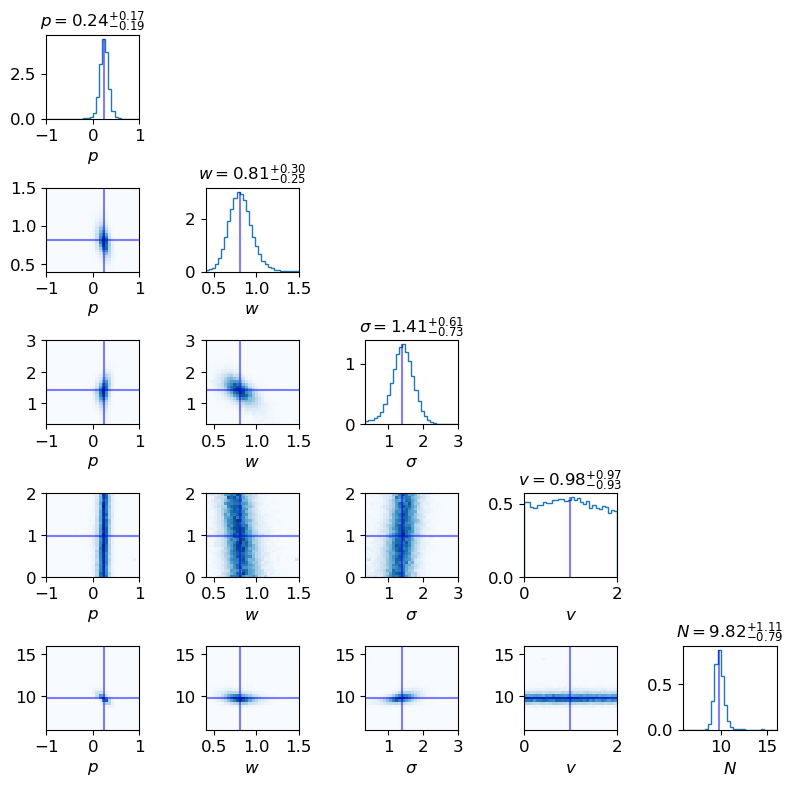

In [27]:
########## Block 26 ##############
#Write_MCMC_chain(samples, parameter_truth, UsePseudoData, PseudoDataIdx, file='chain.h5')
##### Step 7: Analyze the posterior distribution ########
# 1) Run this block and plot the posterior distribution
# 2) Does the posterior fairly estimates the true values (red)?
# 3) How does the posterior change it we take into account the
#    correlation among the sys-error?
figure, axes = plt.subplots(figsize=(8,8), 
                            ncols=ndim, nrows=ndim)
names = [r"$p$",r"$w$",r"$\sigma$",r"$v$",r"$N$"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            H, _,  _ = ax.hist(samples[:,i], bins=30,
                    range=ranges[i], histtype='step', 
                    density=True)
            if UsePseudoData:
                ax.vlines(parameter_truth[i],0,H.max(),color='r',alpha=0.5)
            xmedian = np.quantile(samples[:,i],.5)
            x2d5 = np.quantile(samples[:,i],.025)
            x97d5 = np.quantile(samples[:,i],.975)
            ax.vlines(xmedian,0,H.max(),color='b',alpha=0.5)
            ax.set_title(names[i]+r"$={:1.2f}_{{-{:1.2f}}}^{{+{:1.2f}}}$".format(xmedian,xmedian-x2d5,x97d5-xmedian))
            ax.set_xlabel(names[i])
            ax.set_xlim(*ranges[j])
        if i>j:
            ax.hist2d(samples[:, j], samples[:, i], 
                      bins=30, range=[ranges[j], ranges[i]], 
                      cmap='Blues')
            if UsePseudoData:
                ax.hlines(parameter_truth[i],*ranges[j],color='r',alpha=0.5)
                ax.vlines(parameter_truth[j],*ranges[i],color='r',alpha=0.5)
            ax.hlines(np.quantile(samples[:,i],.5),*ranges[j],color='b',alpha=0.5)
            ax.vlines(np.quantile(samples[:,j],.5),*ranges[i],color='b',alpha=0.5)
            ax.set_xlabel(names[j])
            ax.set_xlim(*ranges[j])
            ax.set_ylim(*ranges[i]) 
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
#plt.savefig("corr-results.png")

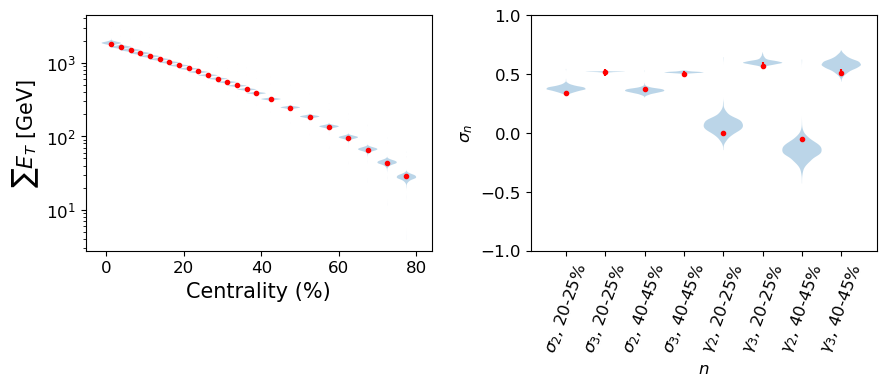

In [28]:
########## Block 27 ##############
# predicting observables
param_samples = samples[np.random.choice(range(len(samples)),1000), :]
Norms = param_samples[:,-1]
pred = np.array([
    GP_pred_at_one_input(theta[:-1], with_truncation_err=True)[0]
    for theta in param_samples
])
pred[:,:24] = (Norms*pred[:,:24].T).T

fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(9,4))
ax1.violinplot( pred[:,:24],obs['0']['ET']['x'], widths=5, showextrema=False)
ax1.errorbar(obs['0']['ET']['x'],yexp[:24], yerr=ystat[:24], fmt='r.', label="Measurements")
ax1.semilogy()
ax1.set_xlabel(r'Centrality (%)', fontsize=15)
ax1.set_ylabel(r'$\sum E_T$ [GeV]', fontsize=15)

ax2.violinplot( pred[:,24:],np.arange(8), showextrema=False, widths=1)
ax2.errorbar(np.arange(8), yexp[24:], yerr=ystat[24:], fmt='r.', label="Measurements")
ax2.set_xticks(np.arange(8))
ax2.set_xticklabels([r"$\sigma_2$, 20-25%",r"$\sigma_3$, 20-25%",
                   r"$\sigma_2$, 40-45%",r"$\sigma_3$, 40-45%",
                 r"$\gamma_2$, 20-25%",r"$\gamma_3$, 20-25%",
                r"$\gamma_2$, 40-45%",r"$\gamma_3$, 40-45%",], rotation=70)
ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"$\sigma_{n}$")
ax2.set_ylim(-1,1)
plt.tight_layout(True)

## Predicting $\sum E_T$ and the full distribution of $\epsilon/\langle\epsilon\rangle$ using the Maximum a Posteriori (MAP)

MAP is the parameter set that maximizes the posterior distribution. It can be loosely understand as a "best fit" result from the analysis. Nevertheless, it does not take into account the full prediciton uncertianty, and the location of the MAP can be sensitive to the choice of prior. Therefore, these values cannot be understood as a unique set of parameters that should be considered superior to other chices sampled from the posterior distribution.


In [29]:
########## Block 28 ##############
from scipy.optimize import minimize

# we minimize the negative of ln(Posterior), 
# with initial guess in the middle of the prior
result = minimize(
        lambda x: -posterior_ln_pdf(x),
        x0=np.median(samples, axis=0),
        tol=1e-8,
        bounds=ranges
    )
print("MAP parameters:")
print("p={:1.3f}, w={:1.3f}, s={:1.3f}, v={:1.3f}, N={:1.3f}".format(*result['x']))
MAP = result['x']

MAP parameters:
p=0.242, w=0.808, s=1.411, v=0.980, N=9.815


In [30]:
########## Block 29 ##############
#call_TRENTo(*np.atleast_2d(MAP[:4]).T, 100000, "MAP_prediction.h5")

Generating point  0  p=0.242, w=0.808, sigma=1.411, v=0.980


KeyboardInterrupt: 

In [31]:
########## Block 30 ##############
MapObs = LoadAndComputeObs("ModelData/trento-data/MAP_raw.h5")

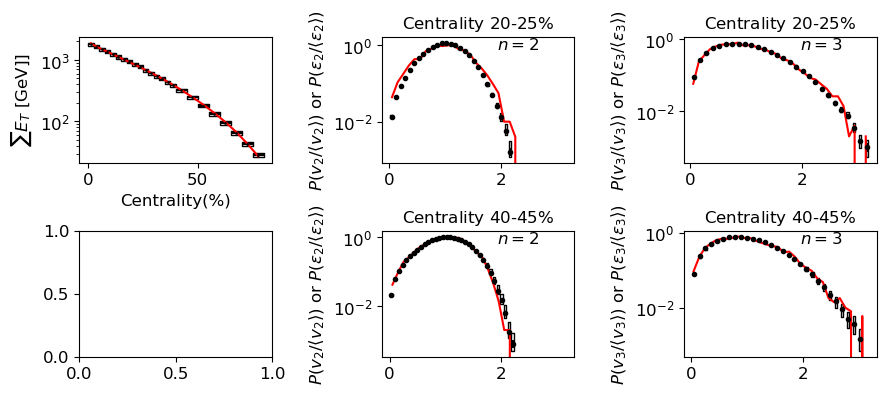

In [32]:
########## Block 31 ##############
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9,4))

x, xl, xh, ET, ETstat, ETsys = np.loadtxt("ExpData/ALICE-ET.dat",usecols=[0,1,2,3,4,6]).T
axes[0,0].errorbar(x, ET, xerr=(xh-xl)/2., yerr=ETstat,label='ALICE',fmt='k.',markersize=2)
for (ixl, ixh, iy, iss) in zip(xl, xh, ET, ETsys):
    axes[0,0].fill_between([ixl,ixh],[iy-iss,iy-iss],
                    [iy+iss,iy+iss],facecolor='none',
                    edgecolor='k')
axes[0,0].set_xlabel("Centrality(%)")
axes[0,0].set_ylabel(r"$\sum E_T$ [GeV]]")
axes[0,0].plot(MapObs['0']['ET']['x'],
             MapObs['0']['ET']['y']*MAP[-1],
             color='r')
axes[0,0].set_xlabel("Centrality(%)")
axes[0,0].semilogy()

for (cenL, cenH), row in zip([(20,25),(40,45)], axes):
    for ax, n in zip(row[1:], [2,3]):
        x, y, stat, sp, sm = np.loadtxt("ExpData/ATLAS-Pv{}-{}-{}.dat".format(n,cenL,cenH), 
                                            usecols=[0,1,2,4,5]).T
        f = interp1d(x, y, kind='linear')
        X = np.linspace(x.min(),x.max(),100)
        xmean = (f(X)*X).sum()/f(X).sum()
        ax.errorbar(x/xmean, y*xmean, yerr=stat*xmean, label='ATLAS, n={:d}, {:d}-{:d}%'.format(n,cenL,cenH), fmt='k.')
        for ix, iy, ip, im in zip(x/xmean, y*xmean, sp*xmean, sm*xmean):
            ax.fill_between([ix-.02, ix+.02], [iy+im, iy+im], [iy+ip, iy+ip], edgecolor='k', facecolor='none')
        ax.set_title(r"Centrality ${:d}$-${:d}$%".format(cenL, cenH))
        ax.plot(MapObs['0']['Pe{}-{}-{}'.format(n,cenL,cenH)]['x'], 
                MapObs['0']['Pe{}-{}-{}'.format(n,cenL,cenH)]['y'],
                color='r'
               )
        ax.annotate(r"$n={:d}$".format(n), xy=(.6, .9),  xycoords="axes fraction")
        ax.semilogy()
        ax.set_ylabel(r"$P(v_{}/\langle v_{} \rangle)$ or $P(\epsilon_{}/\langle \epsilon_{} \rangle)$".format(n,n,n,n))
    
plt.tight_layout(True)